In [1]:
import numpy as np
import pandas as pd  
import os
import glob
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from utils import NPR,\
                  l1_normalized_error,\
                  KNN_MAE,\
                  calculate_Q_metrics,\
                  l1_normalized_error_torch

from IPython.display import clear_output
                
from sklearn.model_selection import train_test_split

In [2]:
DATA_SPECIFICATION = '' #'_pat0.7'
intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict{DATA_SPECIFICATION}.npy', allow_pickle=True).item()

data_pca = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')
        
data_orig = {}
for dataset_name in tqdm(['AGP', 'HMP']):
    for tax in ['o', 'f', 'g']: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
        
embeddings_root = f'./results/embeddings{DATA_SPECIFICATION}/'
os.makedirs(embeddings_root, exist_ok=True)

In [3]:
# # uncomment to use synthetic data

# intrinsic_dims = np.load(f'./intrinsic_dims_pca_strict_synthetic.npy', allow_pickle=True).item()

# data_orig = {}
# for path in glob.glob('data_processed/synthetic/*'):
#     dataframe = pd.read_csv(path, index_col=0)
#     label = path.split('/')[-1].split('.')[0]
#     data_orig[label] = dataframe.values

# data_pca = {}
# for path in tqdm(glob.glob('./results/pca/synthetic/*')):
#     label = path.split('/')[-1]
#     data_pca[label] = np.genfromtxt(path, delimiter = ';')

    
# embeddings_root = 'results/embeddings_synthetic'
# os.makedirs(embeddings_root, exist_ok=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.34it/s]


# Model

In [6]:
class AE(nn.Module):
    def __init__(self, input_dim, z_dim, config):
        hidden_dim = config['hidden_dim']
        dropout_rate1 = config['dropout_rate1']
        dropout_rate2 = config['dropout_rate2']
        dropout_rate3 = config['dropout_rate3']

        dropout_rate4 = config['dropout_rate4']
        dropout_rate5 = config['dropout_rate5']
        dropout_rate6 = config['dropout_rate6']
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                     
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate1), 
                                     
                                    nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.BatchNorm1d(hidden_dim//2), 
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate2),
                                     
                                    nn.Linear(hidden_dim//2, hidden_dim//4),
                                    nn.BatchNorm1d(hidden_dim//4),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate3), 
                                    nn.Linear(hidden_dim//4, z_dim))
        
        self.decoder = nn.Sequential(nn.Linear(z_dim, hidden_dim//4),
                                    nn.BatchNorm1d(hidden_dim//4),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate4),
                                     
                                    nn.Linear(hidden_dim//4, hidden_dim//2),
                                    nn.BatchNorm1d(hidden_dim//2),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate5), 
                                     
                                    nn.Linear(hidden_dim//2, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim), 
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=dropout_rate6),
                                     
                                    nn.Linear(hidden_dim, hidden_dim),
                                    nn.BatchNorm1d(hidden_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(hidden_dim, input_dim))
    def forward(self, X):
        Z = self.encoder(X)
        X = self.decoder(Z)
        return Z,X


In [7]:
def train_ae(ae,
             opt,
             X,
             device,
             n_epochs=6000,
             calc_npr=True, 
             npr_calc_step=100):

    X_train, X_test = train_test_split(X)
    X_tensor = torch.tensor(X, dtype=torch.float).to(device)
        
    X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
    
    torch.manual_seed(42)
    results = defaultdict(list)
    loss_val_min = np.inf

    for i in tqdm(range(n_epochs)):
        #########
        # TRAIN #
        #########
        ae.train()
        # add noise to the input
        ae_input = X_train_tensor + 1e-2*torch.randn_like(X_train_tensor).to(device) # Add noise
        embedding, data_rec = ae(ae_input)
        
        if i%npr_calc_step==0 and calc_npr:
            results['npr_train'].append(NPR(data_train, 
                                        embedding.detach().cpu().numpy()))

        opt.zero_grad()
        loss = l1_normalized_error_torch(X_train_tensor, data_rec).mean() # mean of loss
        loss.backward()
        opt.step()

        results['loss_train'].append(loss.item())

        ##############
        # VALIDATION #
        ##############
        ae.eval()
        with torch.no_grad():
            embedding_, data_rec_test = ae(X_test_tensor)
            loss_ = l1_normalized_error_torch(X_test_tensor, data_rec_test).mean()
            results['loss_val'].append(loss_.item())

            if results['loss_val'][-1] < loss_val_min:
                loss_val_min = results['loss_val'][-1]
                torch.save(ae.state_dict(), 'best_weights')
            
        if i%npr_calc_step==0 and calc_npr:
            results['npr_val'].append(NPR(data_test, 
                                      embedding_.detach().cpu().numpy()))

        # KNN MAE
        Z, _ = ae(X_tensor)
        results['knn_maes'].append(KNN_MAE(X, Z.detach().cpu().numpy(), 
                                           weights='distance', 
                                           averaging='median',
                                           n_neighbors=5))
        
    ae.load_state_dict(torch.load('best_weights'))
    Z, _ = ae(X_tensor)
    
    return Z.detach().cpu().numpy(), ae, opt, results

# Train

In [8]:
config = {'hidden_dim': 1024,
        'dropout_rate1': 0.05,#encoder
        'dropout_rate2': 0.1,#encoder
        'dropout_rate3': 0.1,#encoder
        'dropout_rate4': 0.1,#decoder
        'dropout_rate5': 0.1,#decoder
        'dropout_rate6': 0.05}#decoder

ae_results = {}
ae_embeddings = {}
device = torch.device('cuda:1')

for label,X in tqdm(data_pca.items()):
    intrinsic_dim = intrinsic_dims[label]


    ae = AE(X.shape[1],
            intrinsic_dim,
            config).to(device)

    opt = torch.optim.Adam(ae.parameters(), 
                            lr=5e-4, 
                            weight_decay=1e-5) 

    Z, ae, opt, results = train_ae(ae,
                                    opt,
                                    X,
                                    device,
                                    n_epochs=5000,
                                    calc_npr=False)
    
    ae_results[label] = [ae, opt, results]
    ae_embeddings[label] = Z
    
clear_output()

  0%|                                                                                                                                          | 0/9 [00:00<?, ?it/s]

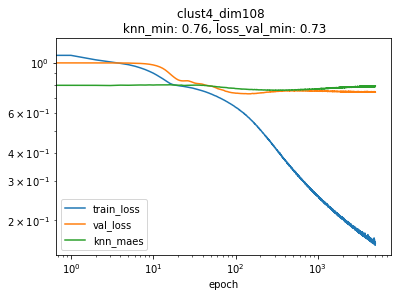

 11%|██████████████▍                                                                                                                   | 1/9 [00:00<00:03,  2.07it/s]

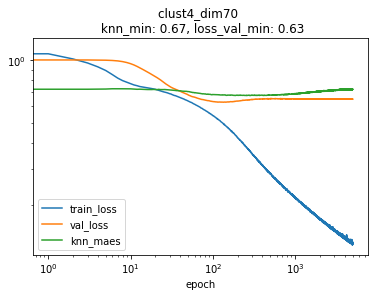

 22%|████████████████████████████▉                                                                                                     | 2/9 [00:00<00:02,  2.65it/s]

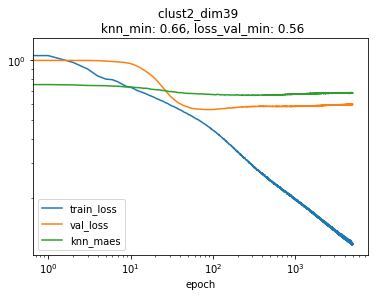

 33%|███████████████████████████████████████████▎                                                                                      | 3/9 [00:01<00:02,  2.58it/s]

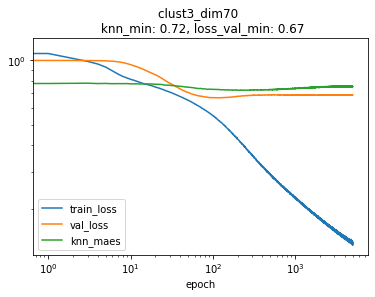

 44%|█████████████████████████████████████████████████████████▊                                                                        | 4/9 [00:01<00:01,  2.82it/s]

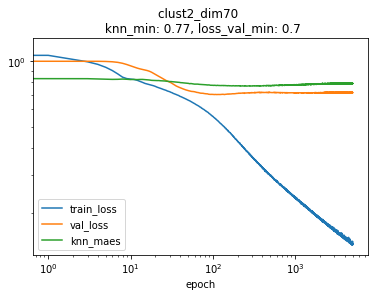

 56%|████████████████████████████████████████████████████████████████████████▏                                                         | 5/9 [00:01<00:01,  2.97it/s]

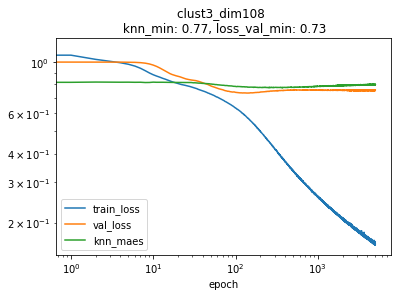

 67%|██████████████████████████████████████████████████████████████████████████████████████▋                                           | 6/9 [00:02<00:01,  2.93it/s]

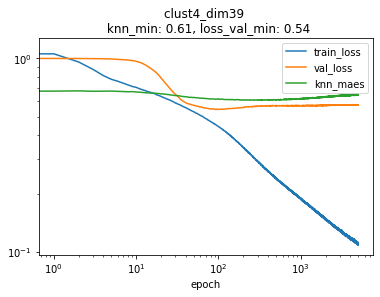

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7/9 [00:02<00:00,  3.00it/s]

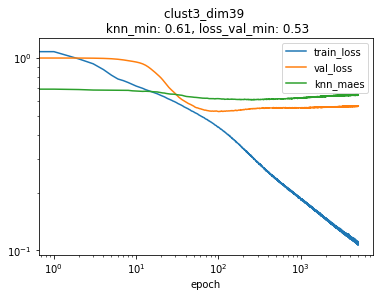

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8/9 [00:02<00:00,  2.77it/s]

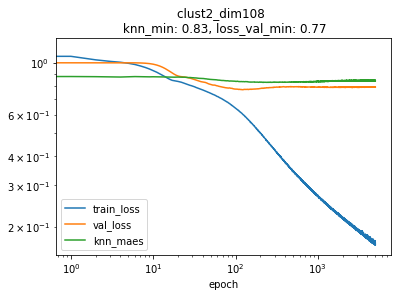

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.78it/s]


In [9]:
for label,(ae, opt, results) in tqdm(ae_results.items()):
    plt.figure()
    plt.plot(results['loss_train'], label='train_loss')
    plt.plot(results['loss_val'], label='val_loss')
    plt.plot(results['knn_maes'], label='knn_maes')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('epoch')
    knn_mae_min = round(min(results['knn_maes']),2)
    loss_val_min = round(min(results['loss_val']),2)
    plt.title(f'{label} \n knn_min: {knn_mae_min}, loss_val_min: {loss_val_min}')
    plt.legend()
    plt.show()

# Embedding

In [10]:
knn_mae_scorer = lambda *args: KNN_MAE(*args, averaging='median', weights='distance', n_neighbors=5)
PERCENTILE = 95
DATA_PERCENT_THRESHOLD = 0.9

for label,Z in ae_embeddings.items():
    
    print(label)
    
    X_orig = data_orig[label]

    mae = knn_mae_scorer(X_orig, Z)
    baseline_mae = knn_mae_scorer(X_orig, X_orig)
    Q_loc, Q_glob = calculate_Q_metrics(X_orig, Z)
    
    d = {}
    
    d['Q_loc'] = Q_loc
    d['Q_glob'] = Q_glob
    d['knn_mae'] = mae
    d['knn_mae_base'] = baseline_mae 

    N = X_orig.shape[0]
    X_ = X_orig.copy()
    Z_ = Z.copy() 

    inliers_indexes = np.arange(N)
    # iteratively choosing subset of high-mae outliers
    maxiter = 20
    for _ in range(maxiter):
        scoring_list = KNN_MAE(X_, Z_, averaging=None, weights='distance', n_neighbors=5) 
        q = np.percentile(scoring_list, PERCENTILE)
        mask = scoring_list < q
        if mask.sum()/N < DATA_PERCENT_THRESHOLD:
            break
        X_ = X_[mask]
        Z_ = Z_[mask]
        inliers_indexes = inliers_indexes[mask]

    outliers_indexes = set(np.arange(N)) - set(inliers_indexes)
    # cast set to np.array
    outliers_indexes = np.array(list(outliers_indexes))

    mae_ = knn_mae_scorer(X_, Z_)
    baseline_mae_ = knn_mae_scorer(X_, X_)
    Q_loc_, Q_glob_ = calculate_Q_metrics(X_, Z_)

    d['inliers_indexes_mae'] = inliers_indexes
    d['outliers_indexes_mae'] = outliers_indexes
    d['X_'] = X_
    d['Z_'] = Z_ # final embedding
    d['Q_loc_'] = Q_loc_ 
    d['Q_glob_'] = Q_glob_ 
    d['knn_mae_'] = mae_ # final mae
    d['knn_mae_base_'] = baseline_mae_ 

    print(f'Initial metrics: mae={mae}, Q_loc={Q_loc}, Q_glob={Q_glob}, baseline_error: {baseline_mae}') 
    print(f'After removing outliers: mae={mae_}, Q_loc={Q_loc_}, Q_glob={Q_glob_}, baseline_error: {baseline_mae_}')
    print('-----------------------------------------------------------','\n')
    
    path = os.path.join(embeddings_root, f'{label}_ae')
    np.save(path, d)

clust4_dim108
Initial metrics: mae=0.43707914088647803, Q_loc=0.5008256374531187, Q_glob=0.7872087432624545, baseline_error: 0.38738849614367743
After removing outliers: mae=0.43138782037811396, Q_loc=0.5171607996783325, Q_glob=0.782820720345836, baseline_error: 0.38385818272649114
----------------------------------------------------------- 

clust4_dim70
Initial metrics: mae=0.40817564607338697, Q_loc=0.5322104126521834, Q_glob=0.8071435657268765, baseline_error: 0.35836838679657457
After removing outliers: mae=0.40221625798239213, Q_loc=0.5462905032365567, Q_glob=0.815114191214022, baseline_error: 0.35336412876722967
----------------------------------------------------------- 

clust2_dim39
Initial metrics: mae=0.38142929481707555, Q_loc=0.5249086231639337, Q_glob=0.8388046732976809, baseline_error: 0.323651827553893
After removing outliers: mae=0.3728654862583256, Q_loc=0.523874390892982, Q_glob=0.850636643736073, baseline_error: 0.31735453458012314
---------------------------------